In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray
import numpy as np 

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (3,3)

# Scicomp Morning Meeting
## Davis Bennett, 2020-09-14

### What I have been doing:
Working on getting a lot (30+) of large (100 GB and up) 3D Electron Microscopy volumes on Amazon S3, and creating a web page for visualizing them (for the COSEM project team).

### Tools I have been using:
Preparing data (python): 
- dask
- xarray
- zarr / n5 / tensorstore

Visualizing data (javascript, typescript):

- react
- neuroglancer

### What I will discuss today:
- Metadata-aware image processing with `xarray`
- Images-as-a-service

### Goals of this presentation
- Describe tools I found useful for managing large image datasets
- Propose a new paradigm for analyzing and visualizing large image datasets

This presentation was made from a jupyter notebook. Both the notebook and the slides rendered from it can be seen in this repo: https://github.com/d-v-b/scicomp-2020-09-15/

## Metadata-aware image processing with `xarray`
###  Why do I care about image metadata?

For the COSEM project team, I work with lots of 3D imaging datasets for which metadata handling is very important.

- Our source data are sampled in real units (electrons) over discrete grids in real space (typical grid spacing: ~4nm)

- We want to visualize these volumes with tools that care about image metadata (e.g., Neuroglancer, BigDataViewer). 

After a few metadata-related headaches, I realized that first-class support for basic image metadata could make my life a lot easier. 

### Arrays are not enough

Core python array libraries (`numpy`, `dask`, `cupy`) provide objects (`{numpy, dask, cupy}` arrays) with a standard interface: These arrays represent n-dimensional regular grids of homogeneously typed elements. 

In [2]:
foo = np.ones((4,4))
print(f'values: \n{foo} \n')
print(f'shape: {foo.shape}\n')
print(f'datatype: {foo.dtype}')

values: 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]] 

shape: (4, 4)

datatype: float64


But scientific images have *metadata* that we need to keep track of

- Semantic labels for array axes, e.g. `('x', 'y', 'z', 't')`

- A mapping from array indices to real coordinates, e.g. array index `[0,0]` may correspond to real position `(-10.5 nm, -10.5 nm)`

- Units for array indices (see above), and for array elements, e.g. `V / M`

- Arbitrary / unstructured metadata, like `{'acquisition_date' : '2020-10-10', 'sample_genotype' : 'GFAP:GCaMP6f'}`

The numpy array interface does not support this semantic layer.

Why not just use separate data structures for data and metadata? E.g.,
```python
data, metadata = get_data_and_metadata(data_source)
```

This approach works for small projects but has drawbacks that get severe at scale:

- Awkward to access array elements in physical coordinates.
    - "position in space" -> "array index" requires verbose and error-prone arithmetic
    ```python
    indices_y = position_to_idx(y, metadata)
    indices_x = position_to_idx(x, metadata)
    value = data[indices_y, indices_x]
    ```


- Hard to keep data and metadata in sync.
    - ```python
    data_2 = mutate_data(data) # if we do this
    metadata_2 = mutate_metadata(metadata) # we must also do this
    ```

A simple solution is to create an object with coupled data and metadata properties. 

Mutations of this object take the signature `f(data, metadata, ...) -> (data, metadata)`

This is the approach taken by the `xarray` library (https://github.com/pydata/xarray), which was originally developed by climate scientists for large N-dimensional data processing.

xarray is actively developed (see https://github.com/pydata/xarray) with funding from numfocus (https://numfocus.org/), and is heavily used in geosciences / climatology, where bigger-than-memeory array datasets are common, but hardly used in biomedical imaging (so far)

### DataArrays

`xarray` has a data structure called DataArray that solves the problems I just described: A DataArray wraps array data in a metadata-aware semantic layer, while retaining the array interface.

a DataArray has:

- `data`: an array-like object

- `coords`: an array of coordinates for array indices of `data` 

- `dims`: labels for axes of `data`, e.g. `('x', 'y')`

- `attrs`: arbitrary metadata

### DataArray demo

Next I will create a DataArray and show what you can do with it.

The following example requires some simulation data, which I create here, along with some metadata.

In [3]:
def make_data(axis_y: np.ndarray, axis_x: np.ndarray) -> np.ndarray:
    from scipy.signal.windows import gaussian
    data = ((np.outer(axis_y, axis_x)).cumsum(0) % 255).astype('float')
    data *= np.outer(*(gaussian(s, s/4) for s in data.shape))
    data = data.astype('uint8')
    return data

In [4]:
dims = ('y','x')
unit = 'nm'
axes = range(-64, 64, 2), range(-64, 64, 2)
data = make_data(*axes)
data

array([[0, 3, 0, ..., 2, 5, 2],
       [3, 4, 4, ..., 2, 2, 2],
       [4, 1, 6, ..., 5, 1, 5],
       ...,
       [4, 1, 6, ..., 5, 1, 5],
       [3, 4, 4, ..., 2, 2, 2],
       [0, 3, 0, ..., 2, 5, 2]], dtype=uint8)

Now I create a DataArray that encapsulates the image data and the metadata:

In [5]:
# defined earlier:
# dims = ('y','x')
# unit = 'nm'
# axes = range(-64, 64, 2), range(-64, 64, 2)

coords ={'y': axes[0], 'x': axes[1]}
xarr = xarray.DataArray(data, dims=dims, coords=coords, name='data', attrs={'Description': 'demo for scicomp'})

# the `coords` attribute itself can have attributes, including a unit
xarr.coords['y'].attrs['units']='nm'
xarr.coords['x'].attrs['units']='nm'

Here's a representation of our DataArray:

In [6]:
print(xarr)

<xarray.DataArray 'data' (y: 64, x: 64)>
array([[0, 3, 0, ..., 2, 5, 2],
       [3, 4, 4, ..., 2, 2, 2],
       [4, 1, 6, ..., 5, 1, 5],
       ...,
       [4, 1, 6, ..., 5, 1, 5],
       [3, 4, 4, ..., 2, 2, 2],
       [0, 3, 0, ..., 2, 5, 2]], dtype=uint8)
Coordinates:
  * y        (y) int64 -64 -62 -60 -58 -56 -54 -52 -50 ... 50 52 54 56 58 60 62
  * x        (x) int64 -64 -62 -60 -58 -56 -54 -52 -50 ... 50 52 54 56 58 60 62
Attributes:
    Description:  demo for scicomp


DataArrays have convenience methods for plotting that incorporate coordinate metadata:

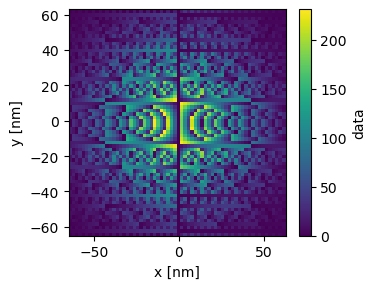

In [7]:
fig, pl_ax = plt.subplots(figsize=(3.5,3))
xarr.plot(ax=pl_ax);

(However, for 100 GB 3D volumes, I don't use 2D plotting very much)

In addition to ordinary array indexing, DataArray allow indexing based on coordinates:

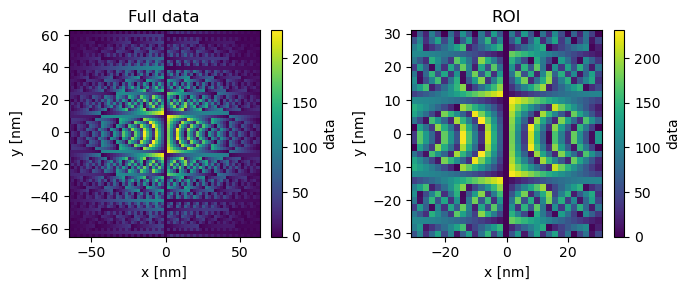

In [8]:
# define square region from -30 nm to 30 nm
yx_region = {'y': slice(-30, 30), 'x': slice(-30, 30)}

# the .sel method operates in coordinate space, not array index space
xarr_roi = xarr.sel(yx_region)

fig, pl_ax = plt.subplots(ncols=2, figsize=(7,3))
xarr.plot(ax=pl_ax[0])
xarr_roi.plot(ax=pl_ax[1])

pl_ax[0].set_title('Full data')
pl_ax[1].set_title('ROI')
plt.tight_layout()

Coordinate-aware indexing is independent from the axis order of the underlying array, which means that these two statements are equivalent:

In [9]:
transposed = xarr.transpose() # axis 0 is now the x axis, and axis 1 is now the y axis
pt = {'y' : 0, 'x': 10}
xarr.sel(pt).data == transposed.sel(pt).data

True

People who have worked with anisotropic or multichannel data will probably understand why this is useful

Mutating a DataArray returns a new DataArray with updated coordinates.

This is useful when indexing with array indices (the result of array indexing should have a subset of the original coordinates)

In [10]:
print(xarr[0,0])

<xarray.DataArray 'data' ()>
array(0, dtype=uint8)
Coordinates:
    y        int64 -64
    x        int64 -64
Attributes:
    Description:  demo for scicomp


This is also useful for more elaborate transformations, like creating a multiscale image pyramid:

In [11]:
scales = range(0,4)
# downscale our data by 1,2,4,8 using a averaging in a square window
multiscale = {f'Scale {s}': xarr.coarsen({'y': 2**s, 'x': 2**s}, keep_attrs=True).mean() for s in scales}

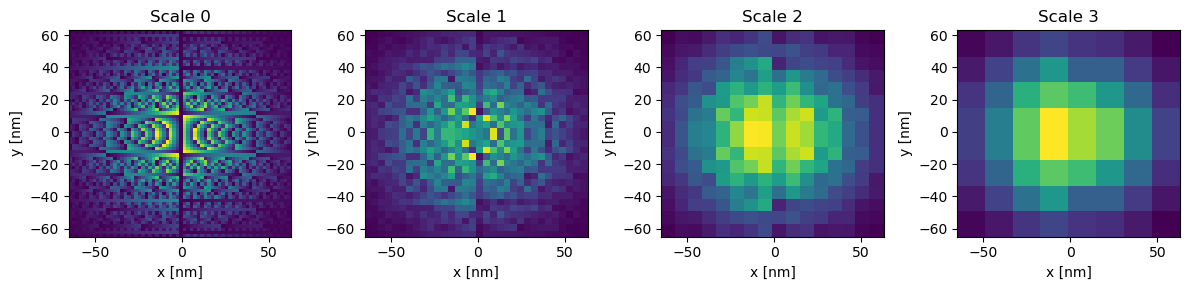

In [12]:
fig, pl_axs = plt.subplots(figsize=(3 * len(multiscale), 3), ncols=len(multiscale))
for m, pl_ax in zip(multiscale.values(), pl_axs):
    m.plot(ax=pl_ax, add_colorbar=False)
[pl_ax.title.set_text(k) for pl_ax, k in zip(pl_axs, multiscale) ]
plt.tight_layout()

This might look like a cute plotting trick, but it's more than that: coordinate-aware data access is *incredibly* useful when you are working with images with multiple resolutions. Even though every scale level of my multiscale pyramid has a different number of samples, I can unformly address each scale level with the same coordinate-aware query: 

In [13]:
# get the lower left quadrant
region = {'y': slice(-60, 0), 'x': slice(-60,0)}

# use coordinate-aware indexing to grab that region from each scale level
multiscale_crop = {k: m.sel(region) for k, m in multiscale.items()}

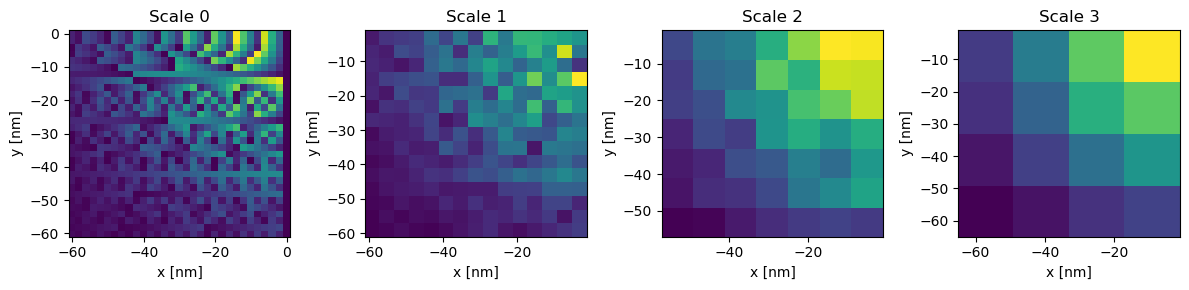

In [14]:
fig, pl_axs = plt.subplots(figsize=(3 * len(multiscale_crop), 3), ncols=len(multiscale_crop))
for k, pl_ax in zip(multiscale_crop, pl_axs):
    multiscale_crop[k].plot(ax=pl_ax, add_colorbar=False)
    pl_ax.title.set_text(k)

plt.tight_layout()

xarray is designed to compose with lower-level array libraries like numpy and dask, so there's minimal friction when trying to use numpy / scipy functions on xarray data:

In [15]:
from scipy.stats import mode
print(mode(xarr, axis=None).mode)

[0]


### xarray / DataArray summary

- xarray DataArrays intelligently combine array data with metadata
- DataArrays fall into the "I wish I used this earlier" category
- This was not an exhaustive tutorial. For more, see the offical docs: http://xarray.pydata.org/en/stable/why-xarray.html

### Images-as-a-service

In COSEM we use neuroglancer (https://github.com/google/neuroglancer) to visualize data stored on cloud storage (aws:s3). 

- Neuroglancer assumes image data will be served in chunks over a RESTful interface. This is what I mean by "Image-as-a-service".

- Neuroglancer's viewer state can be serialized *completely* to a string

- I think it would be cool if more visualization apps used the "Image-as-a-service" architecture.

- I prepared a demo to illustrate